In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import h5py
import json 
import sys 
from scipy.io import FortranFile
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
sys.path.append("/home/sferrone/GC-tidal-loss/experiments/functions/")
import inputMW
import inputGC
import global_functions as GF
from mpl_toolkits import mplot3d
import numba
import orbitCoords as OC
import trace_orbit as TO 
import pandas as pd

ModuleNotFoundError: No module named 'inputMW'

# Goal

Build script to measure the $\bar{\delta y'}$ for left and right side of stream as a function of $\Omega '$, M, $r_c$

# match to theoretical prediction of jacobii radii

$ r_{cutoff}=2.88 \left(\frac{m_{sat} G}{3 v_c^2}\right)^{1/3} r^{2/3}$

Compute the $\Omega$'

In [2]:
k=0
GCnames,version,model=np.loadtxt("clean_stream.txt",delimiter=',',dtype=str,unpack=True)
f=open("config.json")
C = json.load(f)
dt=0.3
backwardpath,forwardpath=TO.orbitpath(C)
streampath=TO.get_streampath(version=version[k],model=model[k])

In [3]:
yprimes=pd.read_csv("gc_yprimes.csv",sep=",")
plt.style.use('dark_background')

In [4]:
stream=h5py.File(streampath+GCnames[k]+".h5")
COM = OC.getCOM(GCnames[k])
mass,radius=inputGC.Plummer(GCnames[k]) 
# load ORBIT
t,W=TO.load_orbit(backwardpath,forwardpath,GCnames[k],C)
cond = np.abs(t) < dt
ts,Ws = t[cond],W[cond,:]
past,future=(ts < 0),(ts > 0)
x,y,z = Ws[:,0],Ws[:,1],Ws[:,2]
vx,vy,vz = Ws[:,3],Ws[:,4],Ws[:,5]
# initialize 
Xp,Yp,Zp=np.array(stream['galactocentric']['X']),np.array(stream['galactocentric']['Y']),np.array(stream['galactocentric']['Z'])
VXp,VYp,VZp=np.array(stream['galactocentric']['VX']),np.array(stream['galactocentric']['VY']),np.array(stream['galactocentric']['VZ'])
xprime,star_coords,indexes,tt=np.zeros(Xp.shape),np.zeros((Xp.shape[0],3)),np.zeros(Xp.shape),np.zeros(Xp.shape)
xprimeORB=np.zeros(x.shape)
xcom,ycom,zcom=COM.x.value,COM.y.value,COM.z.value
xprimeORB=np.zeros(x.shape)
tt=np.zeros(Xp.shape)
xprimeORB=OC.define_orbital_coordinate(x, y, z, xcom, ycom, zcom, xprimeORB)
tt, xprime, star_coords, indexes = OC.getorbcoords(Xp, Yp, Zp, ts, x, y, z, vx, vy, vz, xprimeORB, tt, xprime, star_coords, indexes)
cond0 = stream['energy']['Tescape'][:]>0
cond1 = xprime < 0
cond2 = xprime > 0
cond1 = np.logical_and(cond0,cond1)
cond2 = np.logical_and(cond0,cond2)


In [5]:
# just do for each GC
omegas=[]
omegaNorm=[]
for k in range(len(GCnames)):
    COM=OC.getCOM(GCnames[k])
    rvec=[COM.x.value,COM.y.value,COM.z.value]
    vvec=[COM.v_x.value,COM.v_y.value,COM.v_z.value]
    omega=np.cross(rvec,vvec)/np.linalg.norm(rvec)**2
    omegas.append(omega)
    omegaNorm.append(np.linalg.norm(omega))

In [6]:
topBottom=np.random.rand(len(GCnames))
condB=topBottom<0.5
condT=topBottom>0.5
topBottom[condB]=1
topBottom[condT]=0
cmap = plt.cm.get_cmap("hsv")
omegaNorm=np.array(omegaNorm)
GCnames=np.array(GCnames)
mycolors=[]
sampling=np.linspace(0,1,len(GCnames))
for i in range(len(GCnames)):
    mycolors.append(cmap(sampling[i]))

Text(0.5, 0, '$\\omega$ (km s$^{-1}$ kpc$^{-1}$)')

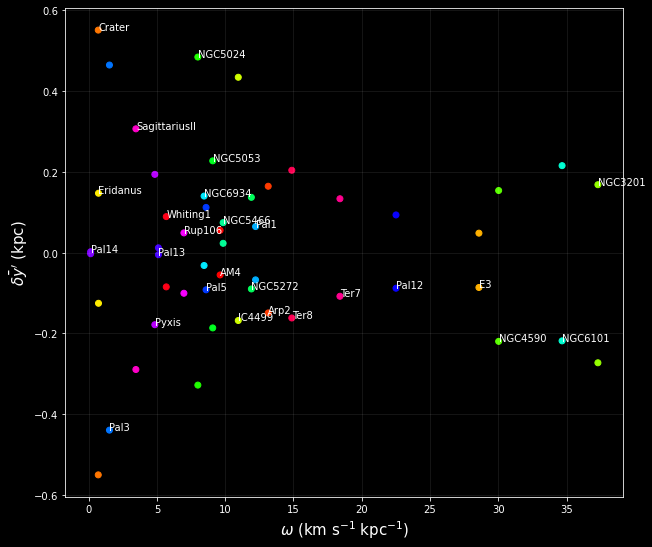

In [7]:
fig,ax=plt.subplots(figsize=(10,9))
ax.scatter(omegaNorm,yprimes['trailing'],c=mycolors)
ax.scatter(omegaNorm,yprimes['leading'],c=mycolors)
ax.grid(True,alpha=0.1)
for k in range(len(GCnames)):
    if topBottom[k]:
        ax.text(omegaNorm[k],yprimes['leading'][k],GCnames[k])
    else:
        ax.text(omegaNorm[k],yprimes['trailing'][k],GCnames[k])

ax.set_ylabel(r"$\bar{\delta y'}$ (kpc)",size=15)
ax.set_xlabel(r"$\omega$ (km s$^{-1}$ kpc$^{-1}$)",size=15)

# get $d\omega/dt$

$\dot{\omega} = \frac{\vec{v}\times \vec{v}}{|r^2|} + \frac{\vec{r}\times \vec{\dot{v}}}{|r^2|} - 2\frac{|v|}{|r^3|}\vec{r}\times \vec{v}$


So i need the acceleration vector at each point... but isnt the acceleration just due to gravity? Therefore parallel to $\vec{r}$

In [8]:
from scipy.interpolate import CubicSpline
t,W=TO.load_orbit(backwardpath,forwardpath,GCnames[k],C)
cond = np.abs(t) < dt
ts,Ws = t[cond],W[cond,:]
past,future=(ts < 0),(ts > 0)
x,y,z = Ws[:,0],Ws[:,1],Ws[:,2]
vx,vy,vz = Ws[:,3],Ws[:,4],Ws[:,5]

In [9]:
vels=[vx,vy,vz]
csx,csy,csz=CubicSpline(ts,vx),CubicSpline(ts,vy),CubicSpline(ts,vz)
ax,ay,az=csx(ts,1),csy(ts,1),csz(ts,1)
csx,csy,csz=CubicSpline(ts,x),CubicSpline(ts,y),CubicSpline(ts,z)
axx,ayy,azz=csx(ts,2),csy(ts,2),csz(ts,2)
vvx,vvy,vvz=csx(ts,1),csy(ts,1),csz(ts,1)

remember! we use silly units in astronomy


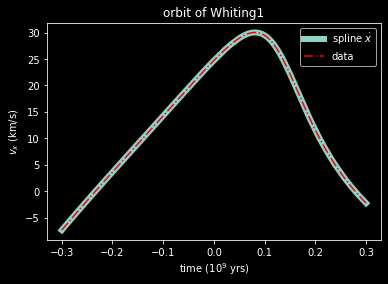

In [10]:
convert=vx.max()/vvx.max()
plt.plot(ts,convert*vvx,linewidth=6,label=r"spline $\dot{x}$")
plt.plot(ts,vx, '-.',c='r',label="data")
plt.xlabel("time (10$^9$ yrs)")
plt.ylabel("$v_x$ (km/s)")
plt.title("orbit of {:s}".format(GCnames[k]))
plt.legend()

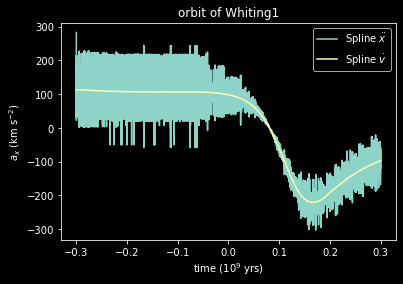

In [11]:
fig,axis=plt.subplots()
axis.plot(ts,convert*axx,label=r"Spline $\ddot{x}$")
axis.plot(ts,ax,label=r"Spline $\dot{v}$")
axis.set_xlabel("time (10$^9$ yrs)")
axis.set_ylabel("$a_x$ (km s$^{-2}$)")
axis.legend()
axis.set_title("orbit of {:s}".format(GCnames[k]));


look at the vectors!

In [12]:
accel=np.zeros((len(vx),3))
accel[:,0],accel[:,1],accel[:,2]=ax,ay,az
xxx=np.cross(accel[0,:],[x[0],y[0],z[0]])
aaa=np.array([ax[0],ay[0],az[0]])
pos=np.array([x[0],y[0],z[0]])
vvv=np.array([vx[0],vy[0],vz[0]])
aaa/=np.linalg.norm(aaa)
pos/=np.linalg.norm(pos)
vvv/=np.linalg.norm(vvv)
xxx/=np.linalg.norm(xxx)
(180/np.pi)*np.arccos(np.dot(aaa,pos))

179.56917834386803

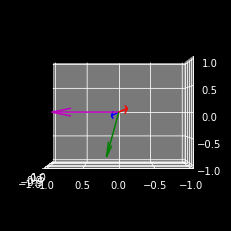

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
axx = fig.add_subplot(111, projection='3d')
axx.quiver(0,0,0,pos[0],pos[1],pos[2],color='r')
axx.quiver(0,0,0,vvv[0],vvv[1],vvv[2],color='g')
axx.quiver(0,0,0,aaa[0],aaa[1],aaa[2],color='b')
axx.quiver(0,0,0,xxx[0],xxx[1],xxx[2],color='m')
axx.set_xlim(-1,1)
axx.set_ylim(-1,1)
axx.set_zlim(-1,1)
axx.view_init(0,180)


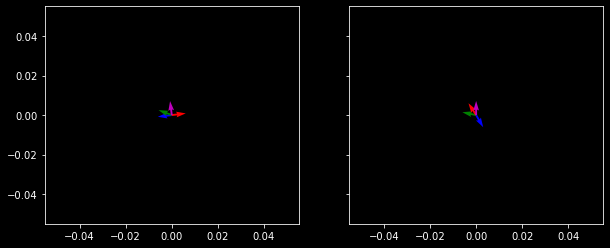

In [14]:
fig,axis=plt.subplots(1,2,figsize=(10,4),sharey=True)
axis[0].quiver(0,0,pos[0],pos[1],color='b')
axis[0].quiver(0,0,vvv[0],vvv[1],color='g')
axis[0].quiver(0,0,aaa[0],aaa[1],color='r')
axis[0].quiver(0,0,xxx[0],xxx[1],color='m')

axis[1].quiver(0,0,pos[2],pos[1],color='b')
axis[1].quiver(0,0,vvv[2],vvv[1],color='g')
axis[1].quiver(0,0,aaa[2],aaa[1],color='r')
axis[1].quiver(0,0,xxx[2],xxx[1],color='m')

# for i in range(2):
    # axis[i].set_xlim(-100,100)
    # axis[i].set_ylim(-100,100)

Text(0.5, 0, 'z comp')

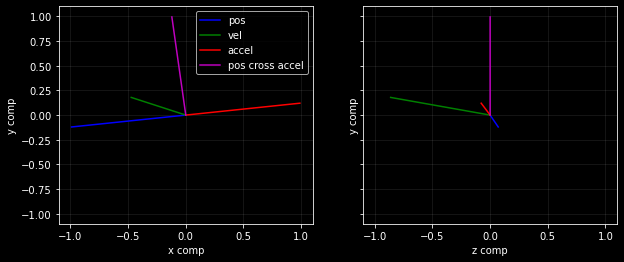

In [15]:
fig,axis=plt.subplots(1,2,figsize=(10,4),sharey=True)
axis[0].plot([0,pos[0]],[0,pos[1]],color='b',label='pos')
axis[0].plot([0,vvv[0]],[0,vvv[1]],color='g',label='vel')
axis[0].plot([0,aaa[0]],[0,aaa[1]],color='r',label='accel')
axis[0].plot([0,xxx[0]],[0,xxx[1]],color='m',label='pos cross accel')

axis[1].plot([0,pos[2]],[0,pos[1]],color='b')
axis[1].plot([0,vvv[2]],[0,vvv[1]],color='g')
axis[1].plot([0,aaa[2]],[0,aaa[1]],color='r')
axis[1].plot([0,xxx[2]],[0,xxx[1]],color='m')
for i in range(2):
    axis[i].set_xlim(-1.1,1.1)
    axis[i].set_ylabel('y comp')
    axis[i].set_ylim(-1.1,1.1)
    axis[i].grid(True,alpha=0.1)

axis[0].legend()
axis[0].set_xlabel('x comp')
axis[1].set_xlabel('z comp')

the pos cross accel should be zero right? Numerics are weird..

# $ \dot{\omega} = - 2\frac{|v|}{|r^3|}\vec{r}\times \vec{v}$

What should I do about units?


In [16]:
omega=np.zeros((len(vx),3))
kminkpc=3.086*10**16
for i in range(len(vx)):
    pos=np.array([x[i],y[i],z[i]])
    pos*=kminkpc
    vel=np.array([vx[i],vy[i],vz[i]])
    rmag = np.linalg.norm(pos)
    velmag=np.linalg.norm(vel)
    omega[i,:] = np.cross(pos,vel)
    omega[i,:] *= -2 * (velmag)/(rmag**3)


In [17]:
odots=np.linalg.norm(omega,axis=1)
speeds=np.linalg.norm(Ws[:,3:6],axis=1)
distances=np.linalg.norm(Ws[:,0:3],axis=1)

Text(0.5, 0, 't ($10^{9}$ yrs)')

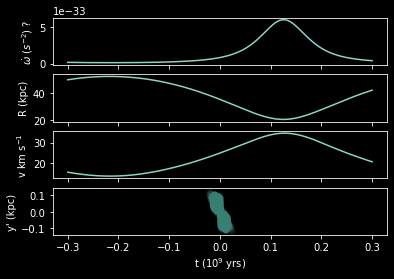

In [18]:
fig,axis=plt.subplots(4,1,sharex=True)
axis[0].plot(ts,odots)
axis[1].plot(ts,distances)
axis[2].plot(ts,speeds)
axis[3].scatter(tt,star_coords[:,0],alpha=0.01)
axis[0].set_ylabel(r'$\dot{\omega}$ ($s^{-2}$) ?')
axis[1].set_ylabel("R (kpc)")
axis[2].set_ylabel(r"v km s$^{-1}$")
axis[3].set_ylabel(r"y' (kpc)")
axis[3].set_xlabel(r"t ($10^{9}$ yrs)")

ok i have omega dot... but this info isn't helpful yet for one stream. 
try to find the omega dot for each part of the orbit. 

In [19]:
from scipy.interpolate import interp1d
omegaFromT = interp1d(ts,odots)
newOmegas = omegaFromT(tt)
testtimes=np.linspace(tt.min(),tt.max(),100)
testOmegaDots=omegaFromT(testtimes)

Text(0, 0.5, 't (Gyrs)')

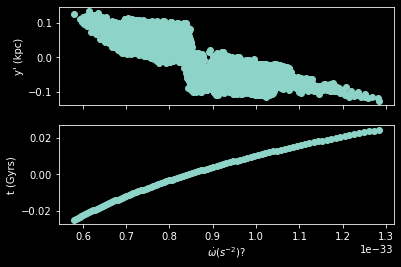

In [20]:
fig,axis=plt.subplots(2,1,sharex=True)

axis[0].scatter(newOmegas,star_coords[:,0])
axis[1].scatter(testOmegaDots,testtimes)
axis[1].set_xlabel(r'$\dot{\omega} (s^{-2}) ?$')
axis[0].set_ylabel("y' (kpc)")
axis[1].set_ylabel("t (Gyrs)")

verify that the interpolation is good

Text(0, 0.5, '$\\dot{\\omega} (s^{-2}) ?$')

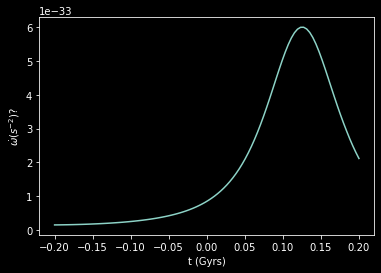

In [21]:
xxxxx=np.linspace(-0.2,0.2,100)
yyyyy=omegaFromT(xxxxx)
plt.plot(xxxxx,yyyyy)
plt.xlabel("t (Gyrs)")
plt.ylabel(r'$\dot{\omega} (s^{-2}) ?$')

Its true that the stream looks a bit more linear with $\dot{\omega}$ that with time

Text(0, 0.5, "y' (kpc)")

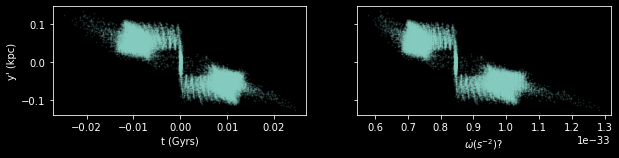

In [22]:
fig,axis=plt.subplots(1,2,sharey=True,figsize=(10,2))
axis[0].scatter(tt,star_coords[:,0],s=1,alpha=0.1)
axis[1].scatter(newOmegas,star_coords[:,0],s=1,alpha=0.1)
axis[1].set_xlabel(r'$\dot{\omega} (s^{-2}) ?$')
axis[0].set_xlabel("t (Gyrs)")
axis[0].set_ylabel(r"y' (kpc)")


maybe they aren't that different? 

Perhaps I should take omega dot at the particle's escape time instead omega dot of the nearest orbital point

In [23]:
Rall=np.linalg.norm(W[:,0:3],axis=1)
Vall=np.linalg.norm(W[:,3:6],axis=1)
allOmegaDot=np.zeros((len(t),3))
kminkpc=3.086*10**16
for i in range(len(t)):
    pos=np.array(W[i,0:3])
    pos*=kminkpc
    vel=np.array(W[i,3:6])
    rmag = np.linalg.norm(pos)
    velmag=np.linalg.norm(vel)
    allOmegaDot[i,:] = np.cross(pos,vel)
    allOmegaDot[i,:] *= -2 * (velmag)/(rmag**3)

In [24]:
allOmegaDotMag=np.linalg.norm(allOmegaDot,axis=1)

In [25]:
tesc=stream['energy']['Tescape'][cond0]
tesc/=10

In [26]:
omegaATtime=interp1d(t,allOmegaDotMag)
omegaDotAtTesc=omegaATtime(tesc)

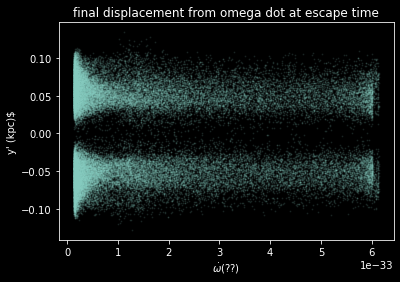

In [36]:
plt.scatter(omegaDotAtTesc,star_coords[cond0,0],s=1,alpha=0.1)
plt.xlabel(r"$\dot{\omega} (??)$")
plt.ylabel(r"y' (kpc)$")
plt.title("final displacement from omega dot at escape time");

this is def wrong

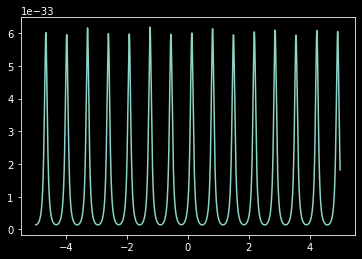

In [28]:
plt.plot(t,allOmegaDotMag)

we should have negative values of omega dot...

# $\dot{\omega} =  \frac{\vec{r}\times \vec{\dot{v}}}{|r^2|} - 2\frac{|v|}{|r^3|}\vec{r}\times \vec{v}$

lets get the acceleration from splines in the good units

Text(0, 0.5, 'km/s/Gyr')

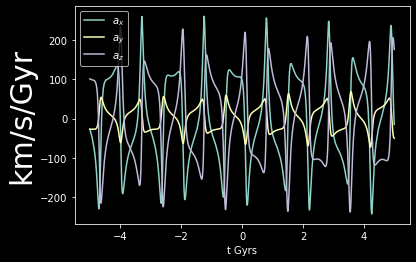

In [29]:
accel=np.zeros((len(t),3))
csx,csy,csz=CubicSpline(t,W[:,3]),CubicSpline(t,W[:,4]),CubicSpline(t,W[:,5])
ax,ay,az=csx(t,1),csy(t,1),csz(t,1)
plt.plot(t,ax,label=r'$a_x$')
plt.plot(t,ay,label=r'$a_y$')
plt.plot(t,az,label=r'$a_z$')
plt.legend()
plt.xlabel("t Gyrs")
plt.ylabel("km/s/Gyr",size=30)

units are def causing issues. Convert to s

Text(0, 0.5, 'km s$^{-2}$')

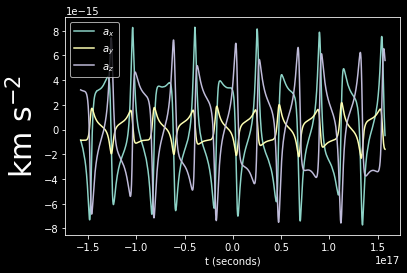

In [30]:
SperYear=(365)*(24)*60*60
tSec=t*SperYear*10**9
accel=np.zeros((len(t),3))
csx,csy,csz=CubicSpline(tSec,W[:,3]),CubicSpline(tSec,W[:,4]),CubicSpline(tSec,W[:,5])
ax,ay,az=csx(tSec,1),csy(tSec,1),csz(tSec,1)
plt.plot(tSec,ax,label=r'$a_x$')
plt.plot(tSec,ay,label=r'$a_y$')
plt.plot(tSec,az,label=r'$a_z$')
plt.legend()
plt.xlabel("t (seconds)")
plt.ylabel(r"km s$^{-2}$",size=30)

 $\dot{\omega} =  \frac{\vec{r}\times \vec{\dot{v}}}{|r^2|} - 2\frac{|v|}{|r^3|}\vec{r}\times \vec{v}$


In [31]:
omegaDotAll=np.zeros((len(t),3))
kminkpc=3.086*10**16
for i in range(len(t)):
    pos=np.array([W[i,0],W[i,1],W[i,2]])
    pos*=kminkpc
    vel=np.array([W[i,3],W[i,4],W[i,5]])
    myaccel=accel[i,:]
    rmag = np.linalg.norm(pos)
    velmag=np.linalg.norm(vel)
    term1 = np.cross(pos,myaccel)/(rmag**2)
    term2 = np.cross(pos,vel)
    term2 *= -2* (velmag)/(rmag**3)
    omegaDotAll[i,:] = term1-term2

NameError: name 'omegaDotMag' is not defined

In [32]:
omegaDotMag=np.linalg.norm(omegaDotAll,axis=1)

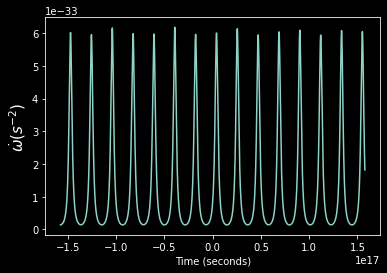

In [33]:
plt.plot(tSec,omegaDotMag)
plt.xlabel("Time (seconds)")
plt.ylabel(r"$\dot{\omega} (s^{-2})$",size=15);

I feel like omega dot must go negative at some points.. otherwise we are only increasing our angular velocity??


Tomorrow I should do more plots of just the velocity. Also, I should also look at characterizing the offset in relation to the quantities normalized to the characteristic radius as Paola was saying. 

I also should find a useful metric for the looking at $\omega$ and $\dot{\omega}$ and do this for all GCs... 

But why am I doing this?? I'm loosing sight of the target... I need to go from STREAM to OG progenitor orbit... Is what I am going bringing me closer to that end??

In [ ]:
# maybe next look at the velocity... 